check random field
check random field
check random field
check div-free field
check div-free field
check div-free field
acc_timestep_crit_constant: 0.25 default: 0.25
acc_timestep_flag: True default: True
adaptive_smoothing_flag: False default: False
artificial_viscosity_alpha: 0.5 default: 0.5
balsara_flag: False default: False
begin_time: 0.0 s default: 0.0 s
beta: 1.0 default: 1.0
code_length_unit: 695500000.0 m default: 3.08567758128e+19 m
code_mass_unit: 9.9446e+29 kg default: 1.98892e+39 kg
conservative_sph_flag: True default: True
cool_par: 6.97039774737e-12 default: 1.0
courant: 0.3 default: 0.3
direct_sum_flag: False default: False
enforce_min_sph_grav_softening_flag: False default: False
eps_is_h_flag: True default: True
epsilon_squared: 4.8372025e+13 m**2 default: 0.0 m**2
feedback: fuv default: fuv
fi_data_directory: /home/lex/amuse/data/fi/input/ default: 
first_snapshot: 0 default: 0
fixed_halo_flag: False default: False
free_timestep_crit_constant_a: 0.35 default: 0.35
f

/home/lex/amuse/src/amuse/units/generic_unit_converter.py:189: RuntimeWarning: overflow encountered in double_scalars
  return new_quantity(number * factor, new_unit)


<IPython.core.display.Javascript object>


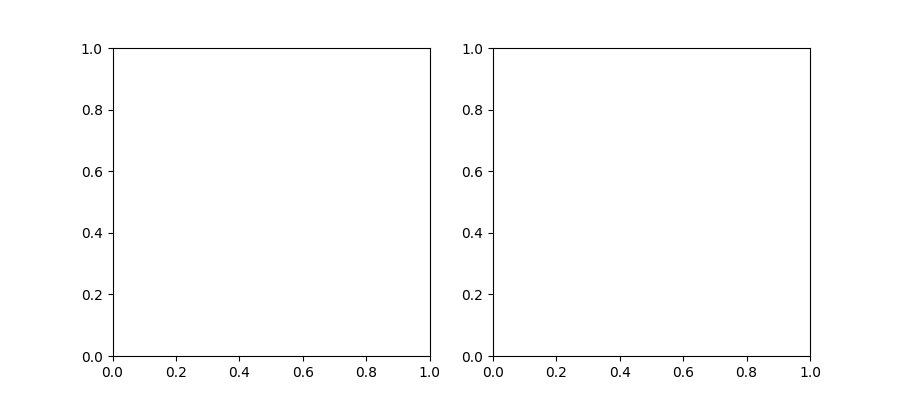

CodeException: The worker application does not exist, it should be at: 
/home/lex/amuse/src/amuse/community/bhtree/bhtree_worker
/home/lex/amuse/src/amuse/rfi/bhtree_worker

In [1]:
%matplotlib notebook

"""
Hydro-Nbody coupling example in AMUSE
small gaseous clump disrupted by stellar binary system

to actually model the hydro, change 
>>> gas_code.particles.add_particles(gas)
to
>>> gas_code.gas_particles.add_particles(gas)

this version uses different codes to compute particles gravity

by Alessandro Alberto Trani 14/06/2018
"""

# comment these lines if you're using python3
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import (
         bytes, dict, int, list, object, range, str,
         ascii, chr, hex, input, next, oct, open,
         pow, round, super,
         filter, map, zip)

from amuse.lab import *
from amuse.couple import bridge
from amuse.datamodel.particles import Channels
from amuse.ext.molecular_cloud import molecular_cloud
import matplotlib.pyplot as plt

conv=nbody_system.nbody_to_si(0.5 | units.MSun, 1 | units.RSun)

#generate initial conditions
star=Particles()
s1 = Particle(
    mass=1 | units.MSun, 
    position=(0.5, 0, 0) | units.AU, 
    velocity=(0, 21, 0) | units.km/units.s)
s2 = Particle(
    mass=1 | units.MSun, 
    position=(-0.5, 0, 0) | units.AU, 
    velocity=(0, -21, 0) | units.km/units.s)
star.add_particle(s1)
star.add_particle(s2)

gas=molecular_cloud(
    nf=32, 
    power=4, 
    targetN=1000, 
    ethep_ratio=0.001, 
    ekep_ratio=1, 
    convert_nbody=conv).result
gas.position += (-1, 1, 0) | units.AU
gas.velocity += (10, -7, 0) | units.km/units.s


#call codes and assign particles
star_code = PhiGRAPE(conv)
star_code.parameters.epsilon_squared = (1e-2 | units.RSun)**2
star_code.particles.add_particles(star)

gas_code = Fi(conv) 
gas_code.parameters.epsilon_squared = (1e-2 | units.RSun)**2
gas_code.particles.add_particles(gas) # note: gas is added as particles, not gas_particles! 
                                      #       we are not actually using hydro in order to speed up things
gas_code.parameters.integrate_entropy_flag = False
gas_code.parameters.n_smooth = 32
gas_code.parameters.periodic_box_size = 1 | units.parsec
print(gas_code.parameters)

#adding channels to copy particle sets to our framework
channel = Channels()
channel.add_channel(star_code.particles.new_channel_to(star))
channel.add_channel(gas_code.particles.new_channel_to(gas))

#set up codes to compute gas-star interactions, BHTree for gas gravity
def new_code_to_calculate_gravity_of_gas_particles():
    result = BHTree(conv)
    return result

def new_code_to_calculate_gravity_of_star_particles():
    result=Hermite(conv)
    return result

#BHTree computes the gravity of Fi particles, Hermite the gravity of PhiGRAPE particles
calculate_gravity_code_gas = bridge.CalculateFieldForCodes(
        new_code_to_calculate_gravity_of_gas_particles,
        input_codes = [gas_code])       
calculate_gravity_code_star = bridge.CalculateFieldForCodes(
        new_code_to_calculate_gravity_of_star_particles,
        input_codes = [star_code]) 

gas_to_star_codes = [calculate_gravity_code_gas]
star_to_gas_codes = [calculate_gravity_code_star]

#define an interaction timestep      
bridge_system = bridge.Bridge(timestep = 0.001 | units.yr)

#add gas, star, and interaction codes to the bridge system
bridge_system.add_system(gas_code, star_to_gas_codes)
bridge_system.add_system(star_code, gas_to_star_codes)

#plotting
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.ion()
fig.show()
fig.canvas.draw()

#evolve the system
tend = 1 | units.yr
dtime = 0.001 | units.yr
time = 0 | units.yr
while time < tend:
    time += dtime
    bridge_system.evolve_model(time)
    #print("evolved to time {:s}".format(time))
    channel.copy()
    
    ax.clear()
    ax2.clear()
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('x [au]')
    ax.set_ylabel('y [au]')
    ax.set_aspect('equal')
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(-1, 1)
    ax2.set_xlabel('x [au]')
    ax2.set_ylabel('z [au]')
    ax2.set_aspect('equal')
    ax.scatter(star.x.value_in(units.AU), star.y.value_in(units.AU))      
    ax.scatter(gas.x.value_in(units.AU), gas.y.value_in(units.AU), c = 'red', s=0.5)     
    ax.text(0.6, 0.8, "{:s}".format(time.as_quantity_in(units.yr)))
    ax2.scatter(star.x.value_in(units.AU), star.z.value_in(units.AU))      
    ax2.scatter(gas.x.value_in(units.AU), gas.z.value_in(units.AU), c = 'red', s=0.5)     
    ax2.text(0.6, 0.8, "{:s}".format(time.as_quantity_in(units.yr)))
    fig.canvas.draw()    
bridge_system.stop()
